In [1]:
import numpy as np 
from scipy.io import loadmat
import os
from os.path import join as opj
from h5py import File
import pandas as pd

# load CLIP from huggingface, load the first N images and extract the features
from transformers import CLIPProcessor, CLIPModel
import torch
import tqdm
from PIL import Image

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
storage_path = "/home/matteo/storage"

base_path = storage_path + "/THINGS_Monkey"
thing_base_path = storage_path + "/THINGS_img/"

data_path = "/srv/nfs-data/sisko/matteoc"
monkey = "N"
os.listdir(base_path)

['THINGS_normMUA_F.mat',
 'THINGS_normMUA_N.mat',
 'THINGS_MUA_trials_F.mat',
 'THINGS_normMUA.mat',
 'things_imgs_F.mat',
 'things_imgs_N.mat',
 'THINGS_MUA_trials_N_old.mat']

In [3]:
things_imgs = File(opj(base_path,f'things_imgs_{monkey}.mat'))
train_imgs = things_imgs['train_imgs']   # group object --> <HDF5 group "/train_imgs" (3 members)>
test_imgs = things_imgs['test_imgs']


In [4]:
def resolve_reference(hdf5_file, ref):
    """
    Resolve an HDF5 dataset reference and convert it into a string.
    """
    data = hdf5_file[ref][:]
    return ''.join(chr(i) for i in data.flatten() if i > 0)

In [5]:
train_classes = []
train_local_paths = []
train_things_paths = []

test_classes = []
test_local_paths = []
test_things_paths = []

with File(opj(base_path, f"things_imgs_{monkey}.mat")) as f:
    train_imgs = f['train_imgs']
    
    train_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['class']]
    train_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['local_path']]
    train_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['things_path']]

    test_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['class']]
    test_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['local_path']]
    test_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['things_path']]

In [10]:
if monkey == "F":
   trials = File(opj(base_path, f"THINGS_MUA_trials_{monkey}.mat"))
else:
   trials = File(opj(data_path, f"monkeys/data_{monkey}/THINGS_MUA_trials.mat"))
df =pd.DataFrame(trials["ALLMAT"][:].T, columns=["#trial_idx", "#train_idx", "#test_idx", "#rep", "#count", "#correct"])

df

,#trial_idx,#train_idx,#test_idx,#rep,#count,#correct
0,1.0,16504.0,0.0,1.0,1.0,1.0
1,2.0,16470.0,0.0,1.0,2.0,1.0
2,3.0,15094.0,0.0,1.0,1.0,1.0
3,4.0,2514.0,0.0,1.0,2.0,1.0
4,5.0,4860.0,0.0,1.0,3.0,1.0
...,...,...,...,...,...,...
25243,25244.0,0.0,40.0,30.0,3.0,4.0
25244,25245.0,13906.0,0.0,1.0,4.0,4.0
25245,25246.0,470.0,0.0,1.0,1.0,4.0
25246,25247.0,15559.0,0.0,1.0,2.0,4.0


In [11]:
data = trials["ALLMUA"][:]

In [ ]:
# np.save(data_path + '/monkeys/trials_allmua.npy', data)
# data = np.load(data_path + '/monkeys/trials_allmua.npy')

# print(data.shape)

(300, 25248, 1024)


## Extract Images

In [ ]:
N = 15000   

train_indices = df[df["#train_idx"]!=0]["#train_idx"].values.astype(int) - 1
test_indices = df[df["#test_idx"]!=0]["#test_idx"].values.astype(int) - 1

sorted_train_img_path = [train_things_paths[i] for i in train_indices]
sorted_test_img_path = [test_things_paths[i] for i in test_indices]

In [9]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_features(model, images):
    images = [Image.open(img).convert("RGB") for img in images]
    inputs = processor(images= images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs

batch = 256
train_features = []
test_features = []

for i in tqdm.trange(0, N, batch):
    features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_train_img_path[i:i+batch]])
    train_features.append(features.cpu().numpy())

for i in tqdm.trange(0, len(sorted_test_img_path), batch):
    features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_test_img_path[i:i+batch]])
    test_features.append(features.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)[:N]
test_features = np.concatenate(test_features, axis=0)


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 12/12 [00:31<00:00,  2.64s/it]


In [15]:
# train_features = np.load(data_path + '/monkeys/train_features.npy')
# test_features = np.load(data_path + '/monkeys/test_features.npy')

train_features = np.load(data_path + '/monkeys/data_N/train_features_N.npy')
test_features = np.load(data_path + '/monkeys/data_N/test_features_N.npy')

In [16]:
train_features.shape, test_features.shape

((15000, 512), (3000, 512))

In [17]:
neural_train_trial_idx = df[df["#train_idx"]!=0]["#trial_idx"].values.astype(int) - 1
neural_test_trial_idx = df[df["#test_idx"]!=0]["#trial_idx"].values.astype(int) - 1

train_neural = data[:,neural_train_trial_idx[:N]]      
test_neural = data[:,neural_test_trial_idx]
print(train_neural.shape, test_neural.shape)     # SHAPE: num_timepoints, observation, electrodes

(300, 15000, 1024) (300, 3000, 1024)


## Avg activity over repetitions

In [18]:
test_neural_avg = []
test_features_avg = []
selected_test_imgs = []
for idx in tqdm.tqdm(np.unique(test_indices)):
    test_neural_avg.append(test_neural[:,test_indices==idx].mean(1))
    #same for the test features
    test_features_avg.append(test_features[test_indices==idx].mean(0))
    selected_test_imgs.append(np.array(sorted_test_img_path)[test_indices==idx][0])

test_neural_avg = np.array(test_neural_avg).transpose(1,0,-1)
test_features_avg = np.array(test_features_avg)
selected_test_imgs = np.array(selected_test_imgs)

print(test_neural_avg.shape, test_features_avg.shape, selected_test_imgs.shape)

100%|██████████| 100/100 [00:01<00:00, 87.75it/s]


(300, 100, 1024) (100, 512) (100,)


In [19]:
test_neural_avg.shape, test_features_avg.shape, train_features.shape, train_neural.shape     # TODO: primi 100 di prestimolo

((300, 100, 1024), (100, 512), (15000, 512), (300, 15000, 1024))

## Time Neural Network

In [20]:
train_neural = train_neural[100:]  # (200, 15000, 1024)
test_neural_avg = test_neural_avg[100:]  # (200, 100, 1024)

In [ ]:
# train_neural = np.load(data_path + '/monkeys/train_neural_retr.npy')
# test_neural_avg = np.load(data_path + '/monkeys/test_neural_avg_retr.npy')

In [21]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
    

class TemporalNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, hidden_dim=768, output_dim=512, num_layers=1, tau=0.05, lr=1e-3, 
                 loss_type="contrastive"):
        super().__init__()

        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=False)
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.tau = tau
        self.lr = lr
        self.loss_type = loss_type
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch, time, hidden)
        final_hidden = rnn_out[:, -1, :]  
        # final_hidden = torch.mean(rnn_out, dim=1)
        return self.mlp(final_hidden)
    
    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(preds, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(preds, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(preds, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(preds, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

class SimpleTCN(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-3, tau=0.05, 
                 loss_type="contrastive"):     # 1e-3
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 128, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.loss_type = loss_type
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, 1024, 200)
        x = self.conv(x).squeeze(-1)  # (batch, 128)
        return self.mlp(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.loss_type == "mse":
            loss = self.loss_mse(self(x), y)
        else:
            cos_matrix = self.cosine_similarity_matrix(self(x), y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if self.loss_type == "mse":
            loss = self.loss_mse(self(x), y)
        else:
            cos_matrix = self.cosine_similarity_matrix(self(x), y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)
            
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    




In [22]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x
    

class TransformerNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, d_model=256, nhead=8, num_layers=4, output_dim=512, tau=0.05, lr=1e-3):
        super().__init__()
        
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)  # mean pooling across time
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_fn = nn.MSELoss()
        self.tau = tau
        self.lr = lr
        self.log_tau = nn.Parameter(torch.tensor(np.log(self.tau), dtype=torch.float32))

    def forward(self, x):  # x: (batch, time, channels)
        x = self.input_proj(x)         # → (batch, time, d_model)
        x = self.pos_encoding(x)       # + positional encodings
        x = self.transformer(x).reshape(x.shape[0], self.d_model, -1)       # → (batch, d_model, time)
        x = self.pooling(x).squeeze(-1)              # mean pooling across time
        return self.mlp(x)             # → (batch, output_dim)
    
    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss_mse = self.loss_fn(preds, y)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss_mse = self.loss_fn(preds, y)
        cos_matrix = self.cosine_similarity_matrix(preds, y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)



In [23]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

batch_size = 128
device = 'cuda:3'
cuda_d = 3

X_train = train_neural.transpose(1, 0, 2)  
Y_train = train_features  
X_test = test_neural_avg.transpose(1, 0, 2)  # shape: (15000, 200, 1024)
Y_test = test_features_avg 

scaler_X = StandardScaler()
X_reshaped = X_train.reshape(-1, X_train.shape[-1])  
# X_reshaped = X_train.reshape(X_train.shape[0], -1)
X_scaled = scaler_X.fit_transform(X_reshaped)
X_train_tensor = torch.tensor(X_scaled.reshape(15000, 200, 1024), dtype=torch.float32, device=device)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1]) 
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_tensor = torch.tensor(X_test_scaled.reshape(100, 200, 1024), dtype=torch.float32, device=device)


In [24]:
dataset = TensorDataset(X_train_tensor, torch.tensor(Y_train, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import geomloss 


class LinearFlatTime(pl.LightningModule):
    def __init__(self, input_dim=1024*200, output_dim=512, lr=1e-3, tau=0.05, loss_type="contrastive"):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.loss_type = loss_type
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):     # shape: (batch, 200, 1024)
        x = x.reshape(x.shape[0], -1)  
        output = self.linear(x)
        return output

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.loss_type == "mse":
            loss = self.loss_mse(self(x), y)
        else:
            cos_matrix = self.cosine_similarity_matrix(self(x), y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if self.loss_type == "mse":
            loss = self.loss_mse(self(x), y)
        else:
            cos_matrix = self.cosine_similarity_matrix(self(x), y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    


class MlpAvgTime(pl.LightningModule):
    def __init__(self, 
                 input_dim=1024, 
                 output_dim=512, 
                 lr=1e-3, 
                 tau=0.05,
                 loss_type="contrastive", 
                 projector_type="linear" 
                ):
        super().__init__()

        self.save_hyperparameters()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(768, output_dim)
        )

        self.linear = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )

        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.loss_type = loss_type
        self.projector_type = projector_type
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):  # shape: (batch, 200, 1024)
        x = x.mean(dim=1)
        if self.projector_type == "mlp":
            return self.mlp(x)
        else:
            return self.linear(x)

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)


In [26]:
class SoftMapping(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-3, 
                 tau=0.05, loss_type="contrastive", projector_type="linear"):   # 1e-3 
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(768, output_dim)
        )
        self.attn_linear = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Dropout(0.5)
        )
        self.line = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.loss_type = loss_type
        self.projector_type = projector_type
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):     # shape: (batch, 200, 1024)
        # attn_weights = torch.softmax(self.attn_linear(x), dim=1)
        attn_weights = torch.sigmoid(self.attn_linear(x))
        # attn_weights = attn_weights / attn_weights.sum(dim=1, keepdim=True)
        attn_out = torch.mean(attn_weights * x, dim=1)                         # TODO: sum or mean
        if self.projector_type == "mlp":    
            output = self.mlp(attn_out)
        else:
            output = self.line(attn_out)
        return output, attn_weights

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)
    
    def ridge_loss(self, y_pred, y_true, alpha):
        mse = F.mse_loss(y_pred, y_true)
        l2_reg = sum(param.pow(2).sum() for param in self.parameters())
        num_params = sum(param.numel() for param in self.parameters())
        l2_reg = l2_reg / num_params
        return mse + alpha * l2_reg

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        output, attn_weights = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output, attn_weights = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss
 
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)   # 1e-4
    

In [ ]:
seed = 42     # 42, 55, 5, 1, 9999
pl.seed_everything(seed, workers=True)
model = SoftMapping(loss_type='contrastive', projector_type='mlp', lr=1e-3)
logger = CSVLogger("/home/repo/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.08, patience=7, verbose=True, mode="min")
trainer = Trainer(max_epochs=50, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
trainer.fit(model, train_loader, val_loader)

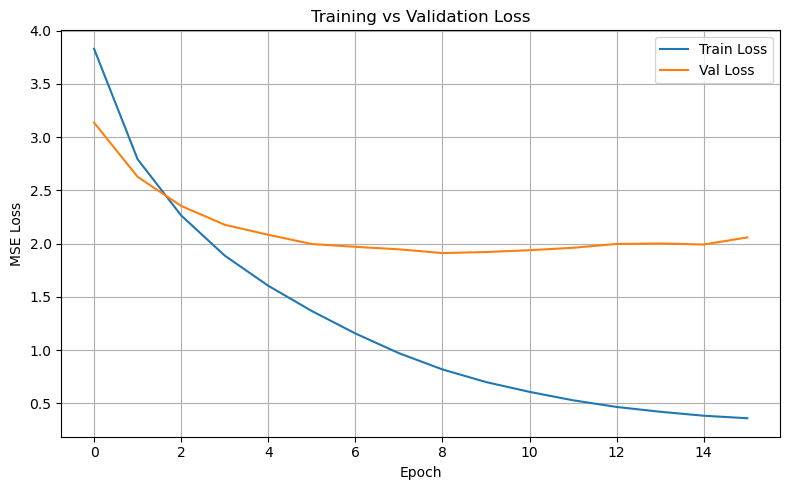

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = logger.log_dir + "/metrics.csv"
df = pd.read_csv(log_path)

val_loss_df = df[~df["val_loss"].isna()]
train_loss_df = df[~df["train_loss_epoch"].isna()]
plt.figure(figsize=(8, 5))
plt.plot(np.array(train_loss_df["epoch"]), np.array(train_loss_df["train_loss_epoch"]), label="Train Loss")
plt.plot(np.array(val_loss_df["epoch"]), np.array(val_loss_df["val_loss"]), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.neighbors import NearestNeighbors
import tqdm
import numpy as np
import os
import random

def set_global_seed(seed):
    pl.seed_everything(seed, workers=True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

top1_scores = []
top5_scores = []

seeds = [42, 55, 5, 1, 9999]

for seed in seeds:
    print(f"\n=== Running for seed: {seed} ===")
    set_global_seed(seed)
    loss_type = "mse"  # "mse" or "contrastive"
    projector_type = "mlp"  # "mlp" or "linear"

    model = SoftMapping(loss_type=loss_type, projector_type=projector_type, lr=1e-3)
    # model = TemporalNeuralToFeature(loss_type=loss_type, lr=1e-3)
    logger = CSVLogger("/home/repo/nlinear-monkeys/logs/", name=f"my_model_seed_{seed}")
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.08, patience=7, verbose=True, mode="min") 
    trainer = Trainer(max_epochs=50, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
    trainer.fit(model, train_loader, val_loader)

    y_pred = []
    y_true = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in tqdm.tqdm(test_loader):
            y_hat, _ = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_pred = torch.cat(y_pred, 0)
    y_true = torch.cat(y_true, 0)

    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)
    distances, top_indices = nbrs.kneighbors(y_pred_np)
    true_indices = np.arange(len(y_true_np))

    top1_count = (top_indices[:, 0] == true_indices).sum()
    top5_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

    top1_acc = top1_count / len(y_true_np)
    top5_acc = top5_count / len(y_true_np)

    print(f"Top-1 accuracy for seed {seed}: {top1_count}/{len(y_true_np)} ({top1_acc * 100:.2f}%)")
    print(f"Top-5 accuracy for seed {seed}: {top5_count}/{len(y_true_np)} ({top5_acc * 100:.2f}%)")

    top1_scores.append(top1_acc)
    top5_scores.append(top5_acc)

mean_top1 = np.mean(top1_scores)
std_top1 = np.std(top1_scores)
mean_top5 = np.mean(top5_scores)
std_top5 = np.std(top5_scores)

print("\n=== Risultati finali ===")
print(f"Average Top-1 accuracy: {mean_top1 * 100:.2f}% ± {std_top1 * 100:.2f}%")
print(f"Average Top-5 accuracy: {mean_top5 * 100:.2f}% ± {std_top5 * 100:.2f}%")


In [29]:
x,y = next(iter(test_loader))

y_pred=[]
y_true=[]
attn_weights_list = []

model.eval()
model.to(device)
with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader):
        y_hat, attn_weights = model(x) 
        y_true.append(y)
        y_pred.append(y_hat)
        attn_weights_list.append(attn_weights.cpu())

y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)
attn_weights_test = torch.cat(attn_weights_list, dim=0).squeeze(-1)

100%|██████████| 1/1 [00:00<00:00, 529.99it/s]


In [34]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 74/100 (74.00%)
Top-5 accuracy: 92/100 (92.00%)


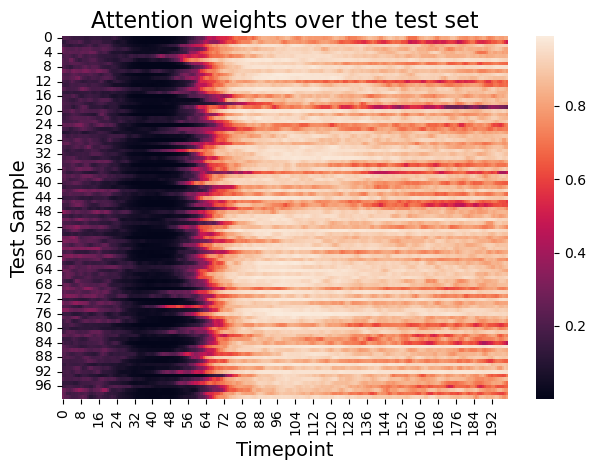

In [31]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

neuroposter_cmap = LinearSegmentedColormap.from_list('Neuroposter', (
    # Edit this gradient at https://eltos.github.io/gradient/#Neuroposter=3C0080-9A5598-CFD357
    (0.000, (0.235, 0.000, 0.502)),
    (0.500, (0.604, 0.333, 0.596)),
    (1.000, (0.812, 0.827, 0.341))))

sns.heatmap(attn_weights_test, cmap='rocket')
plt.title("Attention weights over the test set", fontsize=16)
plt.xlabel("Timepoint", fontsize=14)
plt.ylabel("Test Sample", fontsize=14)
plt.tight_layout()
plt.show()

In [130]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


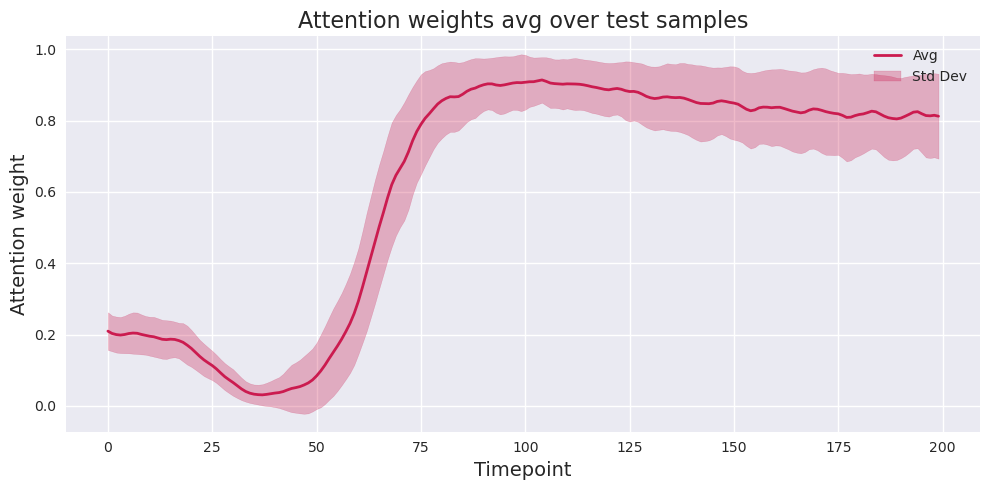

In [32]:
attn_array = attn_weights_test.numpy()  
attn_mean = attn_array.mean(axis=0)  
attn_std = attn_array.std(axis=0)
timepoints = np.arange(attn_mean.shape[0])

rocket_cmap = sns.color_palette("rocket", as_cmap=True)
rocket_colors = sns.color_palette("rocket", 3)
main_color = rocket_colors[1] 

plt.style.use("seaborn") 
plt.figure(figsize=(10, 5))
plt.plot(timepoints, attn_mean, label="Avg", color=main_color, linewidth=2)
plt.fill_between(timepoints, attn_mean - attn_std, attn_mean + attn_std,
                 color=main_color, alpha=0.3, label="Std Dev")

plt.title("Attention weights avg over test samples", fontsize=16)
plt.xlabel("Timepoint", fontsize=14)
plt.ylabel("Attention weight", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


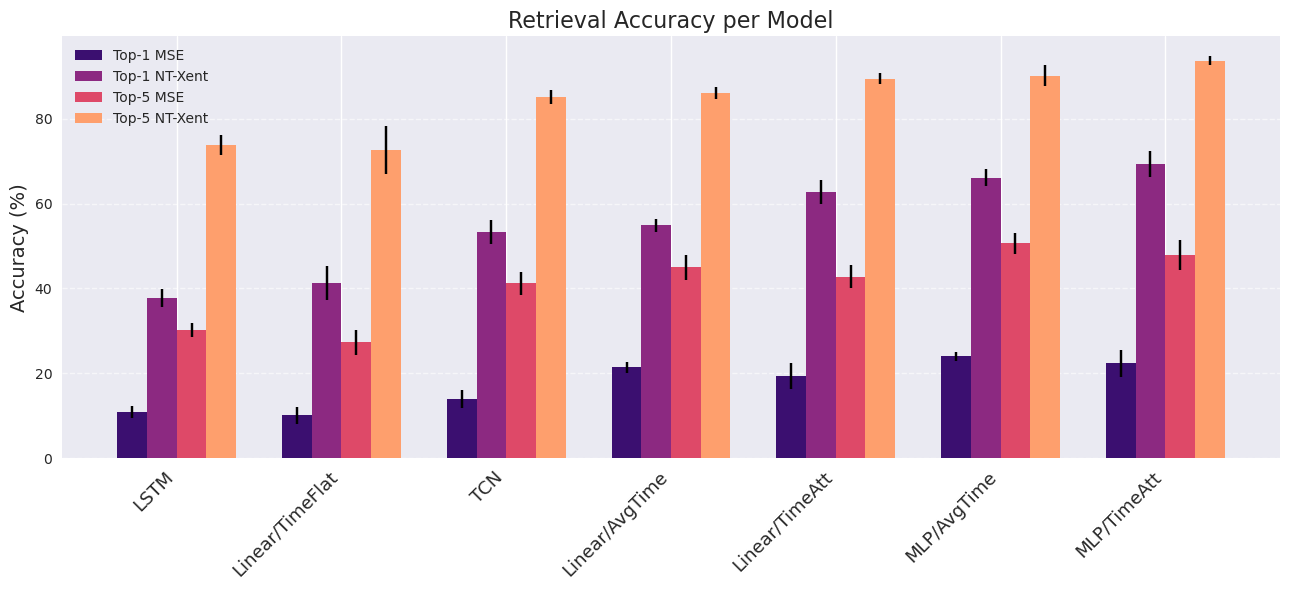

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Dati originali
models = np.array([
    'Linear/TimeFlat', 'Linear/AvgTime', 'MLP/AvgTime',
    'LSTM', 'TCN', 'Linear/TimeAtt', 'MLP/TimeAtt'
])


top1_mse = np.array([10.1, 21.4, 24.0, 11.0, 14.0, 19.4, 22.4])
top1_ntx = np.array([41.3, 54.9, 66.1, 37.7, 53.3, 62.7, 69.3])
top5_mse = np.array([27.3, 45.0, 50.6, 30.2, 41.2, 42.8, 47.8])
top5_ntx = np.array([72.6, 86.0, 90.1, 73.7, 85.1, 89.4, 93.6])

top1_mse_err = np.array([2.10, 1.36, 1.10, 1.41, 2.19, 3.11, 3.14])
top1_ntx_err = np.array([3.92, 1.53, 2.08, 2.06, 2.72, 2.79, 3.01])
top5_mse_err = np.array([2.89, 2.97, 2.42, 1.60, 2.79, 2.70, 3.54])
top5_ntx_err = np.array([5.66, 1.50, 2.48, 2.37, 1.56, 1.34, 1.03])

# Step 1: massimo tra top1_mse e top1_ntx
best_top1 = np.maximum(top1_mse, top1_ntx)

# Step 2: ordina gli indici in base al valore crescente (peggior modello prima)
sorted_indices = np.argsort(best_top1)

# Step 3: riordina tutti i dati
models = models[sorted_indices]
top1_mse = top1_mse[sorted_indices]
top1_ntx = top1_ntx[sorted_indices]
top5_mse = top5_mse[sorted_indices]
top5_ntx = top5_ntx[sorted_indices]

top1_mse_err = top1_mse_err[sorted_indices]
top1_ntx_err = top1_ntx_err[sorted_indices]
top5_mse_err = top5_mse_err[sorted_indices]
top5_ntx_err = top5_ntx_err[sorted_indices]

colors = {
    'top1_mse': '#3b0f70',
    'top1_ntx': '#8c2981',
    'top5_mse': '#de4968',
    'top5_ntx': '#fe9f6d'
}

# Plot
x = np.arange(len(models))
width = 0.18

fig, ax = plt.subplots(figsize=(13, 6))
b1 = ax.bar(x - 1.5*width, top1_mse, width, yerr=top1_mse_err, label='Top-1 MSE', capsize=5, color=colors['top1_mse'])
b2 = ax.bar(x - 0.5*width, top1_ntx, width, yerr=top1_ntx_err, label='Top-1 NT-Xent', capsize=5, color=colors['top1_ntx'])
b3 = ax.bar(x + 0.5*width, top5_mse, width, yerr=top5_mse_err, label='Top-5 MSE', capsize=5, color=colors['top5_mse'])
b4 = ax.bar(x + 1.5*width, top5_ntx, width, yerr=top5_ntx_err, label='Top-5 NT-Xent', capsize=5, color=colors['top5_ntx'])

# Layout
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Retrieval Accuracy per Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=13)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## Top Channels Trials

In [86]:
top_global_channels = torch.load('/srv/nfs-data/sisko/storage/THINGS_img/top_global_channels_F.pt')
print(top_global_channels.shape)

(667,)


In [231]:
top_global_channels_mv = np.array([t.item() for t in top_global_channels])

X_train_tensor = X_train_tensor[:, :, top_global_channels_mv]
X_test_tensor = X_test_tensor[:, :, top_global_channels_mv]

In [232]:
dataset = TensorDataset(X_train_tensor, torch.tensor(train_features, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_features_avg, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
pl.seed_everything(seed, workers=True)
# model_top_channels = SoftMapping(input_dim=667)
# model_top_channels = MlpAvgTime(input_dim=667)
model_top_channels = LinearFlatTime(input_dim=667*200)
logger = CSVLogger("/home/repo/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.10, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=50, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  # Usa GPU se disponibile, 35 epoche per il SoftMapping
trainer.fit(model_top_channels, train_loader, val_loader)

Seed set to 42
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteoc/miniconda3/envs/speech-meg/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | linear       | Sequential | 68.3 M
1 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
68.3 M    Trainable params
0         Non-trainable params
68.3 M    Total params
273.205   Total estimated model params size (MB)


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 47/47 [00:00<00:00, 85.06it/s, v_num=67, train_loss_step=4.900, tau=0.0512, val_loss=5.050, train_loss_epoch=5.360]

Metric val_loss improved. New best score: 5.047


Epoch 1: 100%|██████████| 47/47 [00:00<00:00, 63.50it/s, v_num=67, train_loss_step=3.650, tau=0.0489, val_loss=4.270, train_loss_epoch=4.260]

Metric val_loss improved by 0.777 >= min_delta = 0.1. New best score: 4.270


Epoch 2: 100%|██████████| 47/47 [00:00<00:00, 83.85it/s, v_num=67, train_loss_step=1.580, tau=0.0451, val_loss=3.480, train_loss_epoch=2.110]

Metric val_loss improved by 0.794 >= min_delta = 0.1. New best score: 3.476


Epoch 12: 100%|██████████| 47/47 [00:00<00:00, 85.17it/s, v_num=67, train_loss_step=0.00826, tau=0.0404, val_loss=3.850, train_loss_epoch=0.00775]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.476. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 47/47 [00:05<00:00,  8.80it/s, v_num=67, train_loss_step=0.00826, tau=0.0404, val_loss=3.850, train_loss_epoch=0.00775]


In [244]:
x,y = next(iter(test_loader))

y_pred=[]
y_true=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader):
        model_top = model_top_channels.to(device)
        y_hat = model_top(x)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)

100%|██████████| 1/1 [00:00<00:00, 33.00it/s]


In [245]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 47/100 (47.00%)
Top-5 accuracy: 77/100 (77.00%)


## Channels PCA (Scaling Law)

In [93]:
from sklearn.decomposition import PCA

n_components = 768
pca = PCA(n_components=n_components)
X_train_pca_flat = pca.fit_transform(X_scaled) 
X_train_pca = X_train_pca_flat.reshape(X_train.shape[0], X_train.shape[1], n_components)

X_test_pca_flat = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_flat.reshape(X_test.shape[0], X_test.shape[1], n_components)

X_train_tensor_pca = torch.tensor(X_train_pca.reshape(15000, 200, n_components), dtype=torch.float32, device=device)
X_test_tensor_pca = torch.tensor(X_test_pca.reshape(100, 200, n_components), dtype=torch.float32, device=device)

In [94]:
dataset_pca = TensorDataset(X_train_tensor_pca, torch.tensor(Y_train, dtype=torch.float32, device=device))
test_dataset_pca = TensorDataset(X_test_tensor_pca, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset_pca))  
train_size = len(dataset_pca) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset_pca, val_dataset_pca = random_split(dataset_pca, [train_size, val_size], generator=generator1)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=batch_size, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

In [ ]:
pl.seed_everything(seed, workers=True)
model_pca = SoftMapping(input_dim=n_components, output_dim=512, lr=1e-4, tau=0.05)
logger = CSVLogger("/home/repo/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=100, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
trainer.fit(model_pca, train_loader_pca, val_loader_pca)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | attn_mlp     | Sequential | 197 K 
1 | attn_linear  | Sequential | 769   
2 | lin          | Sequential | 393 K 
3 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
591 K     Trainable params
0         Non-trainable params
591 K     Total params
2.366     Total estimated model params size (MB)


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 94/94 [00:00<00:00, 176.05it/s, v_num=84, train_loss_step=4.420, tau=0.0503, val_loss=4.650, train_loss_epoch=4.850]

Metric val_loss improved. New best score: 4.646


Epoch 1: 100%|██████████| 94/94 [00:00<00:00, 161.24it/s, v_num=84, train_loss_step=3.930, tau=0.0498, val_loss=4.310, train_loss_epoch=4.400]

Metric val_loss improved by 0.339 >= min_delta = 0.09. New best score: 4.307


Epoch 2: 100%|██████████| 94/94 [00:00<00:00, 151.11it/s, v_num=84, train_loss_step=3.650, tau=0.0491, val_loss=3.990, train_loss_epoch=3.990]

Metric val_loss improved by 0.318 >= min_delta = 0.09. New best score: 3.989


Epoch 3: 100%|██████████| 94/94 [00:00<00:00, 170.15it/s, v_num=84, train_loss_step=3.220, tau=0.0483, val_loss=3.690, train_loss_epoch=3.600]

Metric val_loss improved by 0.296 >= min_delta = 0.09. New best score: 3.693


Epoch 4: 100%|██████████| 94/94 [00:00<00:00, 149.07it/s, v_num=84, train_loss_step=2.850, tau=0.0476, val_loss=3.430, train_loss_epoch=3.230]

Metric val_loss improved by 0.260 >= min_delta = 0.09. New best score: 3.433


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 179.49it/s, v_num=84, train_loss_step=2.540, tau=0.0469, val_loss=3.220, train_loss_epoch=2.890]

Metric val_loss improved by 0.214 >= min_delta = 0.09. New best score: 3.219


Epoch 6: 100%|██████████| 94/94 [00:00<00:00, 185.77it/s, v_num=84, train_loss_step=2.310, tau=0.0462, val_loss=3.050, train_loss_epoch=2.620]

Metric val_loss improved by 0.166 >= min_delta = 0.09. New best score: 3.053


Epoch 7: 100%|██████████| 94/94 [00:00<00:00, 158.30it/s, v_num=84, train_loss_step=1.970, tau=0.0456, val_loss=2.930, train_loss_epoch=2.390]

Metric val_loss improved by 0.127 >= min_delta = 0.09. New best score: 2.925


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 154.49it/s, v_num=84, train_loss_step=1.960, tau=0.045, val_loss=2.830, train_loss_epoch=2.210] 

Metric val_loss improved by 0.100 >= min_delta = 0.09. New best score: 2.825


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 142.60it/s, v_num=84, train_loss_step=1.760, tau=0.0439, val_loss=2.680, train_loss_epoch=1.920]

Metric val_loss improved by 0.145 >= min_delta = 0.09. New best score: 2.681


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 135.34it/s, v_num=84, train_loss_step=1.470, tau=0.0429, val_loss=2.580, train_loss_epoch=1.700]

Metric val_loss improved by 0.100 >= min_delta = 0.09. New best score: 2.580


Epoch 15: 100%|██████████| 94/94 [00:00<00:00, 139.13it/s, v_num=84, train_loss_step=1.260, tau=0.0415, val_loss=2.480, train_loss_epoch=1.440]

Metric val_loss improved by 0.103 >= min_delta = 0.09. New best score: 2.477


Epoch 20: 100%|██████████| 94/94 [00:00<00:00, 163.99it/s, v_num=84, train_loss_step=1.010, tau=0.0394, val_loss=2.380, train_loss_epoch=1.140]

Metric val_loss improved by 0.100 >= min_delta = 0.09. New best score: 2.377


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 186.59it/s, v_num=84, train_loss_step=0.723, tau=0.0358, val_loss=2.290, train_loss_epoch=0.746]

Monitored metric val_loss did not improve in the last 10 records. Best score: 2.377. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 174.27it/s, v_num=84, train_loss_step=0.723, tau=0.0358, val_loss=2.290, train_loss_epoch=0.746]


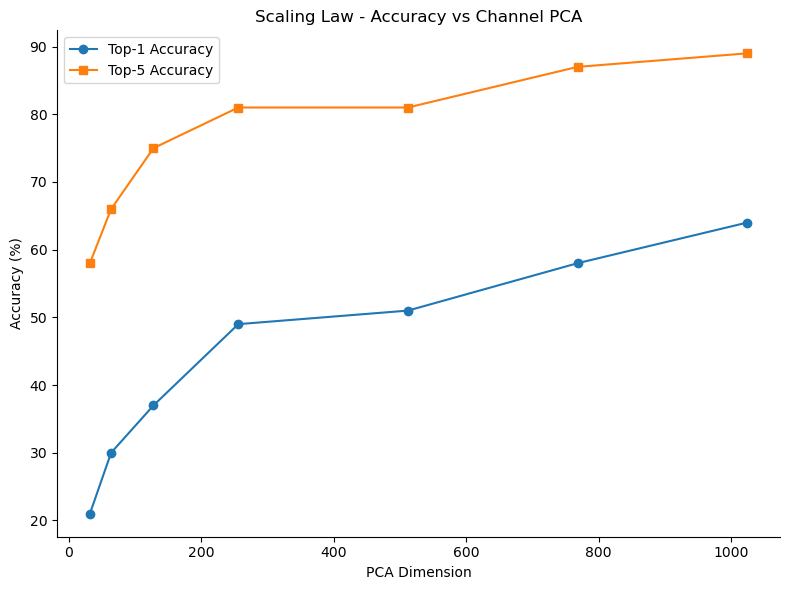

In [ ]:
import matplotlib.pyplot as plt

# Dati della tabella
pca_dims = [32, 64, 128, 256, 512, 768, 1024]
top1_acc = [21.0, 30.0, 37.0, 49.0, 52.0, 59.0, 67.0]
top5_acc = [58.0, 66.0, 75.0, 81.0, 81.0, 87.0, 91.0]

def log_func(x, a, b):
    return a * np.log(x) + b

plt.figure(figsize=(8, 6))
plt.plot(pca_dims, top1_acc, marker='o', label='Top-1 Accuracy')
plt.plot(pca_dims, top5_acc, marker='s', label='Top-5 Accuracy')

plt.xscale('linear')  # scala logaritmica crescente
plt.xlabel('PCA Dimension')
plt.ylabel('Accuracy (%)')
plt.title('Scaling Law - Accuracy vs Channel PCA')
plt.legend()
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## Random Samples (Scaling Law)

In [119]:
num_samples = 10000
torch.manual_seed(seed)

total_samples = X_train_tensor.shape[0]
random_indices = torch.randperm(total_samples)[:num_samples]
X_random_subset = X_train_tensor[random_indices]
Y_train_random = Y_train[random_indices]

dataset = TensorDataset(X_random_subset, torch.tensor(Y_train_random, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset_random, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader_rand = DataLoader(train_dataset_random, batch_size=batch_size, shuffle=True)
val_loader_rand = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_rand = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
pl.seed_everything(seed, workers=True)
model_random = SoftMapping(input_dim=1024, output_dim=512, lr=1e-4, tau=0.05)
logger = CSVLogger("/home/repo/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=10, verbose=True, mode="min")
trainer = Trainer(max_epochs=100, devices=[cuda_d], logger=logger, callbacks=[early_stop_callback])  
trainer.fit(model_random, train_loader_rand, val_loader_rand)

Seed set to 42
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteoc/miniconda3/envs/speech-meg/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | attn_mlp     | Sequential | 262 K 
1 | attn_linear  | Sequential | 1.0 K 
2 | lin          | Sequential | 524 K 
3 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.154     Total estima

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 63/63 [00:00<00:00, 180.82it/s, v_num=90, train_loss_step=3.750, tau=0.0501, val_loss=4.370, train_loss_epoch=4.680]

Metric val_loss improved. New best score: 4.373


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 172.73it/s, v_num=90, train_loss_step=3.260, tau=0.0497, val_loss=3.980, train_loss_epoch=4.100]

Metric val_loss improved by 0.390 >= min_delta = 0.09. New best score: 3.983


Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 183.05it/s, v_num=90, train_loss_step=2.750, tau=0.0492, val_loss=3.720, train_loss_epoch=3.670]

Metric val_loss improved by 0.268 >= min_delta = 0.09. New best score: 3.716


Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 185.26it/s, v_num=90, train_loss_step=2.580, tau=0.0487, val_loss=3.530, train_loss_epoch=3.360]

Metric val_loss improved by 0.184 >= min_delta = 0.09. New best score: 3.531


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 180.70it/s, v_num=90, train_loss_step=2.370, tau=0.0482, val_loss=3.400, train_loss_epoch=3.100]

Metric val_loss improved by 0.134 >= min_delta = 0.09. New best score: 3.398


Epoch 5: 100%|██████████| 63/63 [00:00<00:00, 153.50it/s, v_num=90, train_loss_step=2.320, tau=0.0478, val_loss=3.280, train_loss_epoch=2.900]

Metric val_loss improved by 0.113 >= min_delta = 0.09. New best score: 3.285


Epoch 7: 100%|██████████| 63/63 [00:00<00:00, 193.32it/s, v_num=90, train_loss_step=2.050, tau=0.0469, val_loss=3.130, train_loss_epoch=2.580]

Metric val_loss improved by 0.158 >= min_delta = 0.09. New best score: 3.126


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 188.79it/s, v_num=90, train_loss_step=1.700, tau=0.0461, val_loss=3.000, train_loss_epoch=2.310]

Metric val_loss improved by 0.130 >= min_delta = 0.09. New best score: 2.996


Epoch 11: 100%|██████████| 63/63 [00:00<00:00, 194.37it/s, v_num=90, train_loss_step=1.460, tau=0.0454, val_loss=2.900, train_loss_epoch=2.090]

Metric val_loss improved by 0.093 >= min_delta = 0.09. New best score: 2.903


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 190.89it/s, v_num=90, train_loss_step=1.330, tau=0.0443, val_loss=2.790, train_loss_epoch=1.820]

Metric val_loss improved by 0.115 >= min_delta = 0.09. New best score: 2.788


Epoch 18: 100%|██████████| 63/63 [00:00<00:00, 158.95it/s, v_num=90, train_loss_step=1.010, tau=0.043, val_loss=2.690, train_loss_epoch=1.520] 

Metric val_loss improved by 0.099 >= min_delta = 0.09. New best score: 2.688


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 200.61it/s, v_num=90, train_loss_step=0.782, tau=0.0411, val_loss=2.580, train_loss_epoch=1.180]

Metric val_loss improved by 0.103 >= min_delta = 0.09. New best score: 2.585


Epoch 34: 100%|██████████| 63/63 [00:00<00:00, 180.45it/s, v_num=90, train_loss_step=0.473, tau=0.0385, val_loss=2.510, train_loss_epoch=0.788]

Monitored metric val_loss did not improve in the last 10 records. Best score: 2.585. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 63/63 [00:00<00:00, 159.41it/s, v_num=90, train_loss_step=0.473, tau=0.0385, val_loss=2.510, train_loss_epoch=0.788]


In [121]:
x,y = next(iter(test_loader_rand))

y_pred=[]
y_true=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader_rand):
        model_rand = model_random.to(device)
        y_hat, _ = model_rand(x)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)


y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

100%|██████████| 1/1 [00:00<00:00, 515.14it/s]

Top-1 accuracy: 50/100 (50.00%)
Top-5 accuracy: 82/100 (82.00%)


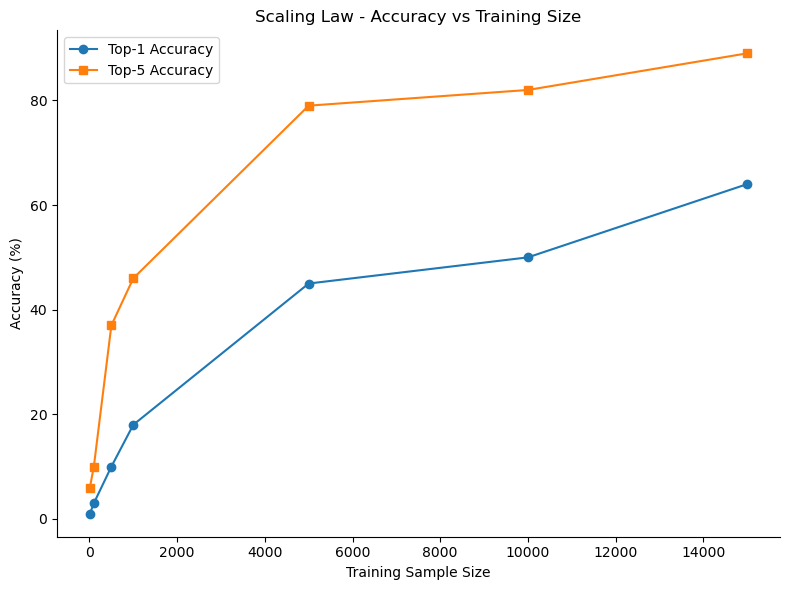

In [ ]:
sample_sizes = [10, 100, 500, 1000, 5000, 10000, 15000]  
top1_acc = [1.0, 3.0, 10.0, 18.0, 45.0, 51.0, 66.0]
top5_acc = [6.0, 10.0, 37.0, 46.0, 79.0, 83.0, 90.0]

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, top1_acc, marker='o', label='Top-1 Accuracy')
plt.plot(sample_sizes, top5_acc, marker='s', label='Top-5 Accuracy')

plt.xscale('linear')  # scala logaritmica crescente
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy (%)')
plt.title('Scaling Law - Accuracy vs Training Size')
plt.legend()
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Ridge Regression

In [92]:
X_train_ridge = X_scaled.reshape(15000, 200, 1024)
X_test_ridge = X_test_scaled.reshape(100, 200, 1024)

In [87]:
top_global_channels_mv = np.array([t.item() for t in top_global_channels])

X_train_ridge = X_train_ridge[:, :, top_global_channels_mv]
X_test_ridge = X_test_ridge[:, :, top_global_channels_mv]

In [100]:
X_train_ridge.shape, X_test_ridge.shape, X_train_ridge.mean(), X_train_ridge.std(), Y_train.mean(), Y_train.std()

((15000, 200, 1024),
 (100, 200, 1024),
 2.8071032442955614e-15,
 0.9999999999999949,
 -0.012036878,
 0.47685653)

In [98]:
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend

vm = RidgeCV(alphas=[0.1,1,10,30,50,100,300])  

device_id = 1
backend = set_backend("torch_cuda")
X_train_F = backend.asarray(torch.tensor(X_train_ridge).float().mean(dim=1).to(f'cuda:{device_id}'))
Y_train_F = backend.asarray(torch.tensor(Y_train).float().to(f'cuda:{device_id}')) 
X_test_F = backend.asarray(torch.tensor(X_test_ridge).float().mean(dim=1).to(f'cuda:{device_id}'))     

vm.fit(X_train_F, Y_train_F)
y_pred_F = vm.predict(X_test_F)

In [99]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_F)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-5 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 37/100 (37.00%)
Top-5 accuracy: 69/100 (69.00%)
